# Image Classification

## Project Subscription

### Objective

使用 CNN 完成 image classification, 将 image 中的食物分类。

### Data Information

#### Number

图片来自 food-11 数据集：

- Training set

    9866 labeled images

- Validation set

    3430 labeled images

- Testing set

    3347 images

一共 11 种食物。

### Format

都是 jpg 格式，但尺寸不一，需要先统一到一个尺寸 (128,128)。

### File

- `./food11/train` - training images : images are named "x_y.png", x is the category

- `./food11/validation` - validation images : images are named "x_y.png", x is the category

- `./food11/test` - testing images : images are named "n.png", n is the id

### Baseline

- Simple

    0.50099

- Medium

    0.73207 Training Augmentation + Train Longer

- Strong

    0.81872 Training Augmentation + Model Design + Train Looonger (+Cross Validation + Ensemble)

- Boss

    0.88446 Training Augmentation + Model Design + Test Time Augmentation(TTA) + Train Looonger (+ Cross Validation + Ensemble) 

### Tips

- Data Augmentation

    - when training
    
        将图片随机变换，label 保持一致。

    - TTA（Test Time Augmentation）

        测试时对图片随机做 4 次变换，取 4 张平均结果与单独原图预测结果的加权和。

- more train set

    当前验证集比例过大，使用更大的训练集会更有效，重新分配比例。

## Space Analysis

In [1]:
def space_analysis():
    BYTE_TO_MB = 1024
    BYTE_TO_GB = 1024 * 1024

    print('### Disk')
    print('dataset size:')
    print('training + validation = 895 M')
    print('test = 237 M')

    print('### RAM')
    image_size = 128 * 128 * 3   # RGB
    train_file_num = 9866
    valid_file_num = 3430
    test_set_num = 3347
    transform_num = 5

    print('after transformation in (training + validation):')
    example_num = train_file_num + valid_file_num
    print(f'example list size = {example_num * image_size * transform_num / BYTE_TO_GB} G')
    max_filename_length = 10
    print(f'filename list size = {example_num * transform_num * max_filename_length / BYTE_TO_MB} M')

    print('### GPU')
    one_batch = image_size
    print(f'one batch size = {one_batch / BYTE_TO_MB} M')
    arr = [16, 32, 64, 128, 256]
    for i in arr:
        print(f'{i} batch size = {i * one_batch / BYTE_TO_GB} G')

space_analysis()

### Disk
dataset size:
training + validation = 895 M
test = 237 M
### RAM
after transformation in (training + validation):
example list size = 3116.25 G
filename list size = 649.21875 M
### GPU
one batch size = 48.0 M
16 batch size = 0.75 G
32 batch size = 1.5 G
64 batch size = 3.0 G
128 batch size = 6.0 G
256 batch size = 12.0 G


## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import random

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configruation

In [10]:
class Config:
    # data path
    training_path = 'food11/training/'
    validaiton_path = 'food11/validation/'
    test_path = 'food11/test/'

    kaggle_path = '../input/ml2022spring-hw3b/'
    current_path = os.getcwd()
    if 'kaggle/working' in current_path:
        training_path = kaggle_path + training_path
        validaiton_path = kaggle_path + validaiton_path
        test_path = kaggle_path + test_path
    
    # environment
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed = 923
    best_train_model_save_path = 'best-train-model.ckpt'
    best_valid_model_save_path = 'best-valid-model.ckpt'
    best_acc_model_save_path = 'best-acc-model.ckpt'
    best_train_prediction_save_path = 'best-train-prediction.csv'
    best_valid_prediction_save_path = 'best-valid-prediction.csv'
    best_acc_predicttion_save_path = 'best-acc-prediction.csv'

    # data format
    image_size = (128, 128)

    # training
    n_epoch = 100
    n_example = math.inf
    batch_size = 64
    laerning_rate = 1e-4
    weight_decay = 1e-1

    # runing test
    runing_test = False
    if runing_test:
        n_epoch = 10
        n_example = 200
        batch_size = 8

print(f'using {Config.device} device')

using cpu device


## General Operation

In [3]:
def same_seed(seed): 
    torch.backends.cudnn.deterministic = True   # 卷积都使用默认的卷积算法
    torch.backends.cudnn.benchmark = False   # 关闭系统卷积算法选择优化（带随机性）
    np.random.seed(seed)   # 为随机算法设置种子。
    torch.manual_seed(seed)   # 为 CPU 设置种子。
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)   # 为所有 GPU 设置种子。

def split_train_valid(data, valid_ratio, seed):
    valid_size = int(len(data) * valid_ratio)
    train_size = len(data) - valid_size
    train_set, valid_set = random_split(data, [train_size, valid_size], generator=torch.Generator().manual_seed(seed))
    return train_set, valid_set

same_seed(Config.seed)

## Data Processing

In [4]:
def add_dir_marker(files, filenames, dir_id):   # dir_id: training is 0, validation is 1, testing is 2.
    for x in filenames:
        files.append([dir_id, x])

def get_files(is_test):
    files = []
    if is_test:
        filenames = os.listdir(Config.test_path)
        add_dir_marker(files, filenames, 2)
    else:
        filenames = os.listdir(Config.training_path)
        add_dir_marker(files, filenames, 0)
        filenames = os.listdir(Config.validaiton_path)
        add_dir_marker(files, filenames, 1)
    end = Config.n_example if Config.n_example != math.inf else len(filenames)   # for runing test
    return files[:end]

def load_image(file):
    if file[0] == 0:
        dir = Config.training_path
    elif file[0] == 1:
        dir = Config.validaiton_path
    else:
        dir = Config.test_path
    image = Image.open(dir + file[1])
    return image

def get_label(file):
    name = file[1].split('_')
    if len(name) <= 1:
        return None
    else:
        return int(name[0])

In [6]:
train_files = get_files(False)
train_files, valid_files = split_train_valid(train_files, 0.2, Config.seed)

## Data Augmentation

In [5]:
policy = transforms.AutoAugmentPolicy.IMAGENET   # 一种随机图像变换的策略
train_augmenter = transforms.Compose([
    transforms.Resize(Config.image_size),
    transforms.AutoAugment(policy),
    transforms.ToTensor()
])

simple_transformer = transforms.Compose([
    transforms.Resize(Config.image_size),
    # transforms.AutoAugment(policy),
    transforms.ToTensor()   # into batch should be Tensor or Ndarray
])

test_augmenter = transforms.Compose([   # also used by validation
    transforms.ToPILImage(),   # into AutoAugment should be PIL
    transforms.AutoAugment(policy),
    transforms.ToTensor()
])

## Data Integration

In [6]:
class FoodDataset(Dataset):
    def __init__(self, files, transformer):
        super().__init__()
        self.files = files
        self.transformer = transformer

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        image = load_image(file)
        label = get_label(file)
        if label is None:
            return self.transformer(image)
        else:
            return self.transformer(image), label

In [9]:
train_set = FoodDataset(train_files, train_augmenter)
valid_set = FoodDataset(valid_files, simple_transformer)
train_loader = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=Config.batch_size, shuffle=True)

## Model Structure

In [11]:
class CNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]
        )

    def forward(self, x):
        return self.layer(x)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # input dimension is [3, 128, 128]
        # self.cnn = nn.Sequential(
        #     nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

        #     nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

        #     nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

        #     nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
        #     nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        # )

        self.in_channels = [3, 64, 128, 256, 512]
        self.out_channels = [64, 128, 256, 512, 512]
        # self.in_channels = [3, 32, 64, 128]
        # self.out_channels = [32, 64, 128, 256]
        self.cnn_layers = nn.ModuleList([CNNLayer(self.in_channels[i], self.out_channels[i]).to(Config.device) for i in range(len(self.in_channels))])
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            # nn.Linear(256*8*8, 1024),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(128, 11),
        )

    def forward(self, x):
        for i in range(len(self.in_channels)):
            x = self.cnn_layers[i](x)
        x = x.flatten(start_dim=1, end_dim=-1)
        x = self.fc(x)
        return x

model = Classifier().to(Config.device)

In [11]:
print(model)

Classifier(
  (cnn_layers): ModuleList(
    (0): CNNLayer(
      (layer): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.5, inplace=False)
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): CNNLayer(
      (layer): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.5, inplace=False)
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): CNNLayer(
      (layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

## Training Loop

In [12]:
def training(model, train_loader, valid_loader):
    epoch_train_loss = []
    epoch_valid_loss = []
    epoch_acc = []
    best_train_loss = math.inf
    best_valid_loss = math.inf
    best_acc = -1

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.laerning_rate, weight_decay=Config.weight_decay)
    for epoch in range(Config.n_epoch):

        batch_train_loss = []
        batch_valid_loss = []
        batch_acc = []

        model.train()
        for batch in train_loader:
            images, labels = batch
            images = images.to(Config.device)
            labels = labels.to(Config.device)
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            # grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            
            batch_train_loss.append(loss.item())            

        model.eval()
        for batch in valid_loader:
            images, labels = batch
            images = images.to(Config.device)
            labels = labels.to(Config.device)
            logits = model(images)
            loss = criterion(logits, labels)

            batch_valid_loss.append(loss.item())
            acc = (logits.argmax(dim=1) == labels).float().mean().cpu()
            batch_acc.append(acc)
        
        train_mean_loss = np.mean(batch_train_loss)
        valid_mean_loss = np.mean(batch_valid_loss)
        mean_acc = np.mean(batch_acc)
        epoch_train_loss.append(train_mean_loss)
        epoch_valid_loss.append(valid_mean_loss)
        epoch_acc.append(mean_acc)
        print(f'### [{epoch + 1}/{Config.n_epoch}] train loss = {train_mean_loss:.4f}, valid loss = {valid_mean_loss:.4f}, acc = {mean_acc:.4f}')

        if train_mean_loss < best_train_loss:
            best_train_loss = train_mean_loss
            torch.save(model.state_dict(), Config.best_train_model_save_path)
            print(f'### [{epoch + 1}/{Config.n_epoch}] best train model saved ###')
        if valid_mean_loss < best_valid_loss:
            best_valid_loss = valid_mean_loss
            torch.save(model.state_dict(), Config.best_valid_model_save_path)
            print(f'### [{epoch + 1}/{Config.n_epoch}] best valid model saved ###')
        if  mean_acc > best_acc:
            best_acc = mean_acc
            torch.save(model.state_dict(), Config.best_acc_model_save_path)
            print(f'### [{epoch + 1}/{Config.n_epoch}] best acc model saved ###')

    return epoch_train_loss, epoch_valid_loss, epoch_acc
    
train_loss, valid_loss, epoch_acc = training(model, train_loader, valid_loader)
print(f'best train loss = {np.min(train_loss):.4f}, best valid loss = {np.min(valid_loss):.4f}, best acc = {np.max(epoch_acc):.4f}')

### [1/10] train loss = 0.2586, valid loss = 0.0128, acc = 1.0000
### [1/10] best train model saved ###
### [1/10] best valid model saved ###
### [1/10] best acc model saved ###
### [2/10] train loss = 0.0000, valid loss = 0.0003, acc = 1.0000
### [2/10] best train model saved ###
### [2/10] best valid model saved ###
### [3/10] train loss = 0.0000, valid loss = 0.0002, acc = 1.0000
### [3/10] best train model saved ###
### [3/10] best valid model saved ###
### [4/10] train loss = 0.0002, valid loss = 0.0005, acc = 1.0000


KeyboardInterrupt: 

## Loss Curve

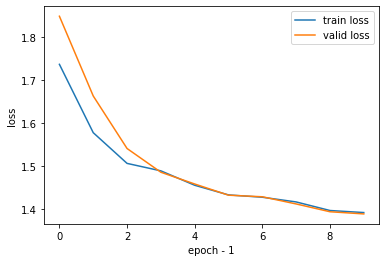

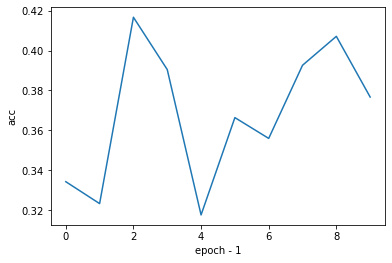

In [ ]:
def loss_curve(train_loss, valid_loss, epoch_acc):
    x = list(range(len(train_loss)))
    plt.figure()
    plt.xlabel('epoch - 1')
    plt.ylabel('loss')
    plt.plot(x, train_loss, label='train loss')
    plt.plot(x, valid_loss, label='valid loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch - 1')
    plt.ylabel('acc')
    plt.plot(x, epoch_acc)
    plt.show()

loss_curve(train_loss, valid_loss, epoch_acc)

## Prediction

In [14]:
def predict(model, test_loader, path):
    model.load_state_dict(torch.load(path, map_location=torch.device(Config.device)))
    answers = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images = batch.to(Config.device)
            finall_logits = model(images) * 0.5

            for _ in range(4):   # 4 times augmentation
                augmented = torch.zeros(*images.shape).to(Config.device)

                for i, image in enumerate(images):   # each image in a batch
                    augmented[i] = test_augmenter(image)

                logits = model(augmented)
                finall_logits += 0.5 * 0.25 * logits
            
            answers += finall_logits.argmax(dim=1).tolist()

    return answers
        
def save_answers(answers, path):
    Id = [f'{i:04d}' for i in range(1, len(answers) + 1)]
    df = pd.DataFrame({'Category': answers}, index=Id)
    df.to_csv(path, index_label='Id')
    print('prediction saved')
    
files = get_files(True)
test_set = FoodDataset(files, simple_transformer)
test_loader = DataLoader(test_set, batch_size=Config.batch_size)
model = Classifier().to(Config.device)

# answers = predict(model, test_loader, Config.best_train_model_save_path)
# save_answers(answers, Config.best_train_prediction_save_path)

# answers = predict(model, test_loader, Config.best_valid_model_save_path)
# save_answers(answers, Config.best_valid_prediction_save_path)

answers = predict(model, test_loader, Config.best_acc_model_save_path)
save_answers(answers, Config.best_acc_predicttion_save_path)

prediction saved
